In [53]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
import os
import pandas as pd
import numpy as np

data_folder = r"C:\Users\abedi\Downloads\pulse oximeter project\bidmc-ppg-and-respiration-dataset-1.0.0\bidmc_csv"
csv_files = [f for f in os.listdir(data_folder) if "Numerics" in f]

features_list = []

def extract_features(spo2: pd.Series, hr: pd.Series) -> dict:
    # Preprocessing: Handle NaNs and Implausible Values
    spo2 = spo2.dropna()
    hr = hr.dropna()

    # Physiological plausibility checks
    spo2 = spo2[(spo2 >= 50) & (spo2 <= 100)]
    hr = hr[(hr >= 20) & (hr <= 220)]

    # Feature Extraction
    return {
        'spo2_mean': np.nanmean(spo2),
        'spo2_var': np.nanvar(spo2),
        'spo2_max_jump': np.nanmax(np.abs(np.diff(spo2))) if len(spo2) > 1 else 0,
        'spo2_stuck_count': (spo2.diff() == 0).sum(),
        'hr_mean': np.nanmean(hr),
        'hr_var': np.nanvar(hr),
        'hr_max_jump': np.nanmax(np.abs(np.diff(hr))) if len(hr) > 1 else 0,
        'hr_stuck_count': (hr.diff() == 0).sum()
    }

for file in csv_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    
    # Strip spaces from column names
    df.columns = df.columns.str.strip()
    
    # Check for required columns
    if 'SpO2' in df.columns and 'HR' in df.columns:
        spo2 = df['SpO2']
        hr = df['HR']
        features = extract_features(spo2, hr)
        features['recording'] = file
        features_list.append(features)
    else:
        print(f"Skipping {file}: required columns not found")

# Convert to DataFrame
features_df = pd.DataFrame(features_list)

# Normalization: Scale features across recordings
features_df.iloc[:, :-1] = (features_df.iloc[:, :-1] - features_df.iloc[:, :-1].mean()) / (features_df.iloc[:, :-1].std() + 1e-6)

print(features_df.head())

   spo2_mean  spo2_var  spo2_max_jump  spo2_stuck_count   hr_mean    hr_var  \
0   0.054928 -0.574238       0.167333         -0.245827  0.162045 -0.508636   
1   0.992585 -0.870732       0.167333          1.004172  0.142976 -0.416947   
2  -0.300903  0.069840       0.167333          0.475326 -0.950765 -0.197132   
3  -1.140180 -0.739178       0.167333          0.763787  0.243839  0.265028   
4   0.806253 -0.100199       0.167333         -0.870826  0.684487 -0.532770   

   hr_max_jump  hr_stuck_count              recording  
0    -0.148906        0.758659  bidmc_01_Numerics.csv  
1    -0.543508        0.498874  bidmc_02_Numerics.csv  
2     0.245695       -0.944375  bidmc_03_Numerics.csv  
3    -0.148906        0.248711  bidmc_04_Numerics.csv  
4    -0.740809        0.623955  bidmc_05_Numerics.csv  


C:\Users\abedi\AppData\Local\Temp\ipykernel_18156\2164827453.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    -0.245827
1     1.004172
2     0.475326
3     0.763787
4    -0.870826
5     1.100326
6     1.004172
7     1.100326
8     1.100326
9    -0.822750
10   -0.197750
11   -0.726596
12    0.811864
13   -1.207365
14    0.667634
15    0.523403
16   -0.438135
17    0.523403
18   -3.803516
19    0.186865
20    1.100326
21   -1.015057
22   -0.534288
23    0.331095
24   -0.341981
25   -0.966980
26    1.052249
27    0.427249
28   -0.197750
29   -0.438135
30    1.100326
31   -1.736210
32   -0.534288
33    1.004172
34   -0.341981
35    0.715710
36    0.331095
37   -0.630442
38    0.331095
39   -1.063134
40    1.100326
41    1.004172
42   -0.005443
43   -0.870826
44    1.100326
45   -2.505440
46    0.234942
47   -0.293904
48    0.042634
49    0.138788
50    0.234942
51   -0.822750
52    1.100326
Name: spo2_stuck_co

In [ ]:
# Train Isolation Forest & Flag Anomalies (single source of truth)
from sklearn.ensemble import IsolationForest

feature_cols = [
    'spo2_mean','spo2_var','spo2_max_jump','spo2_stuck_count',
    'hr_mean','hr_var','hr_max_jump','hr_stuck_count'
]

X = features_df[feature_cols].copy()

model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)

# Anomaly scores: higher = more anomalous
scores = -model.decision_function(X)
features_df['anomaly_score'] = scores

# Choose threshold (top 5%)
percentile = 95
threshold = np.percentile(scores, percentile)
features_df['is_faulty'] = features_df['anomaly_score'] > threshold

print(f"Anomaly threshold (percentile {percentile}%): {threshold:.4f}")
display(features_df[['recording','anomaly_score','is_faulty']].sort_values('anomaly_score', ascending=False).head(10))

Anomaly threshold (percentile 95%): 0.0000


,recording,anomaly_score,is_faulty
40,bidmc_41_Numerics.csv,0.091777,True
44,bidmc_45_Numerics.csv,0.059413,True
18,bidmc_19_Numerics.csv,0.000965,True
21,bidmc_22_Numerics.csv,-0.000644,False
52,bidmc_53_Numerics.csv,-0.006912,False
11,bidmc_12_Numerics.csv,-0.009606,False
20,bidmc_21_Numerics.csv,-0.011699,False
24,bidmc_25_Numerics.csv,-0.013154,False
45,bidmc_46_Numerics.csv,-0.020924,False
31,bidmc_32_Numerics.csv,-0.043701,False


In [56]:
# Show recordings flagged as faulty
faulty = features_df[features_df['is_faulty']]
print(faulty[['recording', 'anomaly_score']])

                recording  anomaly_score
18  bidmc_19_Numerics.csv       0.000965
40  bidmc_41_Numerics.csv       0.091777
44  bidmc_45_Numerics.csv       0.059413


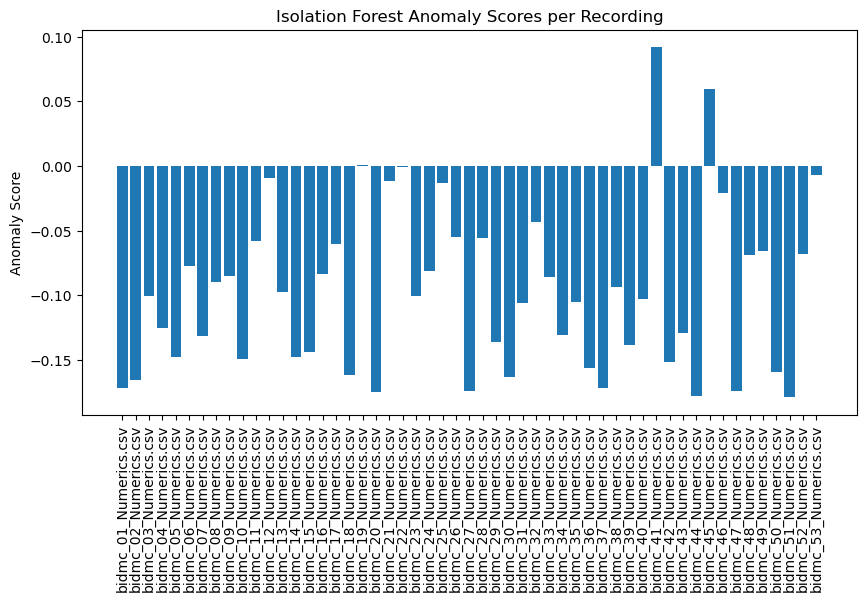

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(features_df['recording'], features_df['anomaly_score'])
plt.xticks(rotation=90)
plt.ylabel('Anomaly Score')
plt.title('Isolation Forest Anomaly Scores per Recording')
plt.show()

In [58]:
threshold = np.percentile(features_df['anomaly_score'], 95)  # top 5% anomalies
features_df['is_faulty'] = features_df['anomaly_score'] > threshold

In [59]:
faulty_recordings = features_df[features_df['is_faulty']]
print(faulty_recordings[['recording', 'anomaly_score']])

                recording  anomaly_score
18  bidmc_19_Numerics.csv       0.000965
40  bidmc_41_Numerics.csv       0.091777
44  bidmc_45_Numerics.csv       0.059413


In [60]:
# Flag anomalies based on top percentile
threshold = np.percentile(features_df['anomaly_score'], 95)  # top 5% most anomalous
features_df['is_faulty'] = features_df['anomaly_score'] > threshold

print("Threshold for anomalies:", threshold)
print("\nFlagged faulty recordings:")
display(features_df[features_df['is_faulty']][['recording', 'anomaly_score']])

Threshold for anomalies: 1.9949319973733282e-17

Flagged faulty recordings:


,recording,anomaly_score
18,bidmc_19_Numerics.csv,0.000965
40,bidmc_41_Numerics.csv,0.091777
44,bidmc_45_Numerics.csv,0.059413


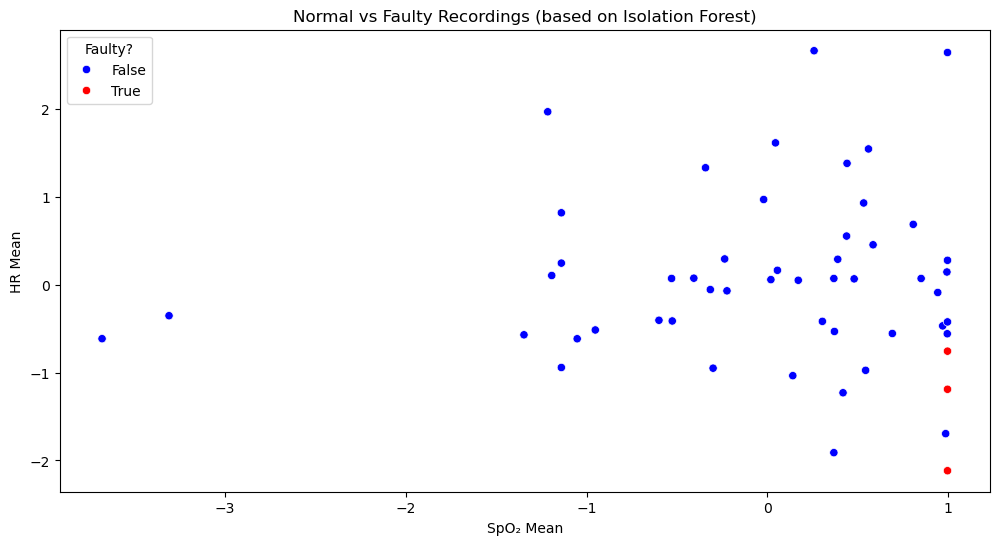

In [61]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=features_df, 
    x="spo2_mean", 
    y="hr_mean", 
    hue="is_faulty", 
    palette={True: "red", False: "blue"}
)
plt.title("Normal vs Faulty Recordings (based on Isolation Forest)")
plt.xlabel("SpO₂ Mean")
plt.ylabel("HR Mean")
plt.legend(title="Faulty?")
plt.show()

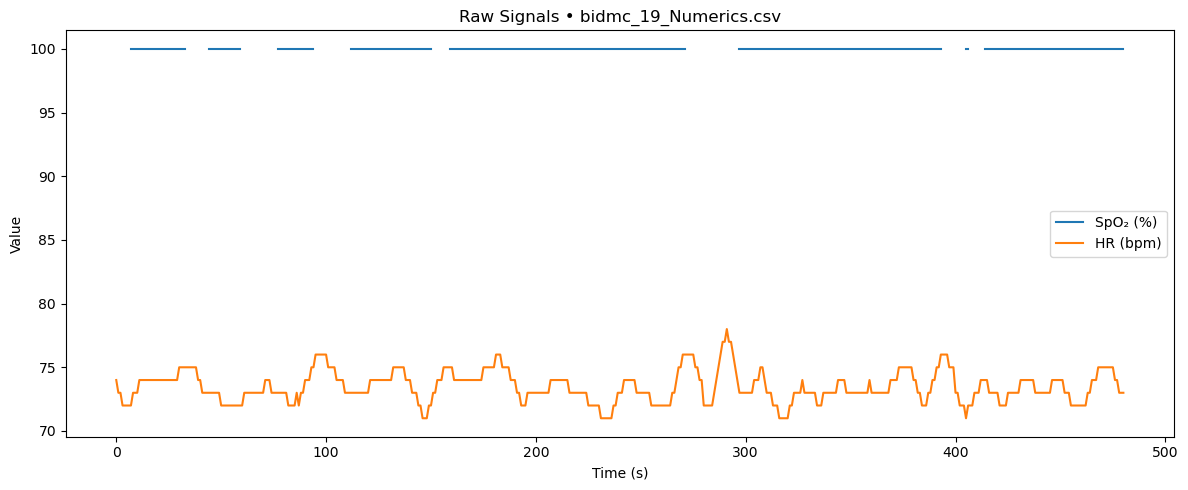

In [ ]:
# Inspect Faulty Recordings (Raw Signals)
import matplotlib.pyplot as plt

def plot_signals(file_path):
    """
    Plot SpO2 and HR time series from a BIDMC Numerics CSV.
    Handles leading/trailing spaces in column names.
    """
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # normalize column names
    
    # Required columns after stripping
    required = {'Time [s]', 'SpO2', 'HR'}
    missing = [c for c in required if c not in df.columns]
    if missing:
        print(f"Missing columns in {file_path}: {missing}")
        print("Available columns:", list(df.columns))
        return
    
    t = df['Time [s]']
    spo2 = df['SpO2']
    hr = df['HR']

    plt.figure(figsize=(12, 5))
    plt.plot(t, spo2, label="SpO₂ (%)")
    plt.plot(t, hr, label="HR (bpm)")
    plt.title(f"Raw Signals • {os.path.basename(file_path)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: plot the first flagged faulty recording (if any)
faulty_rows = features_df[features_df['is_faulty']]
if not faulty_rows.empty:
    faulty_file = faulty_rows['recording'].iloc[0]
    file_path = os.path.join(data_folder, faulty_file)
    plot_signals(file_path)
else:
    print("No faulty recordings flagged with current threshold.")

In [63]:
print("Summary:")
print(f"Total recordings analyzed: {len(features_df)}")
print(f"Flagged as faulty: {features_df['is_faulty'].sum()}")
print("\nNext steps: Validate flagged recordings manually by inspecting raw signals.")

Summary:
Total recordings analyzed: 53
Flagged as faulty: 3

Next steps: Validate flagged recordings manually by inspecting raw signals.


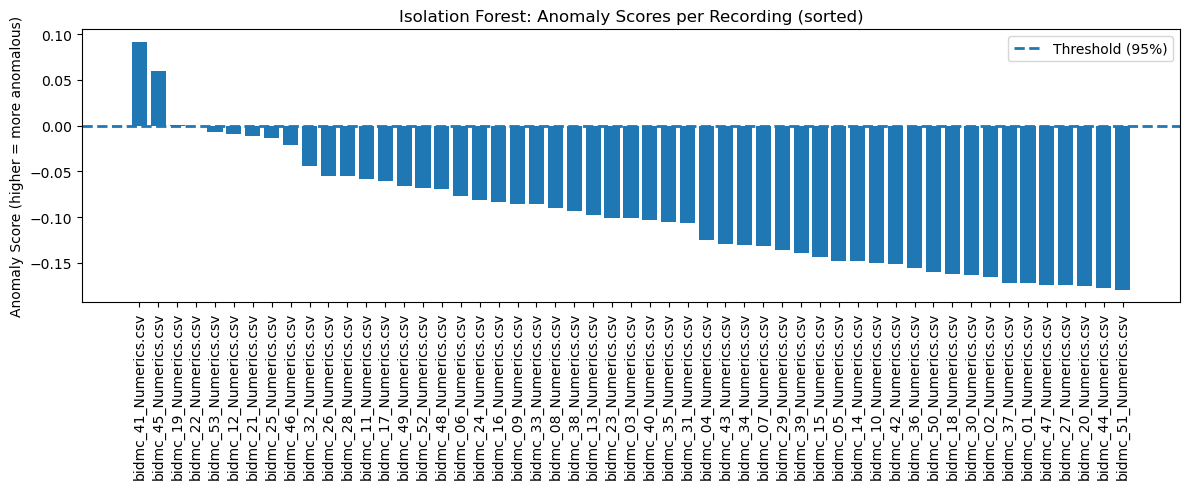

In [64]:
# Bar plot of anomaly scores (sorted) with threshold line
sorted_df = features_df.sort_values('anomaly_score', ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(sorted_df['recording'], sorted_df['anomaly_score'])
plt.axhline(threshold, linestyle='--', linewidth=2, label=f"Threshold ({percentile}%)")
plt.xticks(rotation=90)
plt.ylabel('Anomaly Score (higher = more anomalous)')
plt.title('Isolation Forest: Anomaly Scores per Recording (sorted)')
plt.legend()
plt.tight_layout()
plt.show()

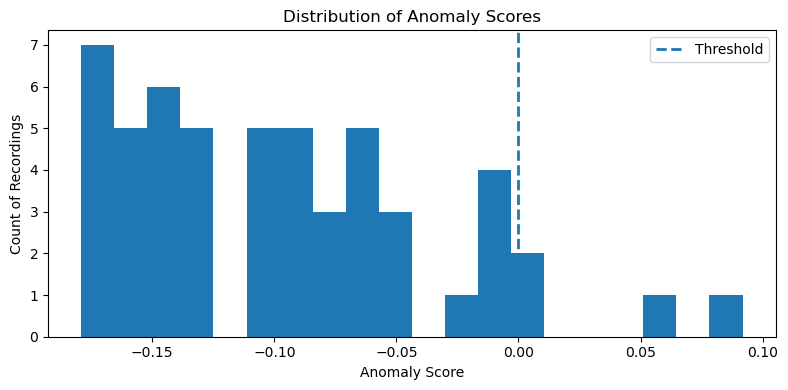

In [65]:
# Histogram of anomaly scores
plt.figure(figsize=(8, 4))
plt.hist(features_df['anomaly_score'], bins=20)
plt.axvline(threshold, linestyle='--', linewidth=2, label="Threshold")
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Count of Recordings")
plt.legend()
plt.tight_layout()
plt.show()

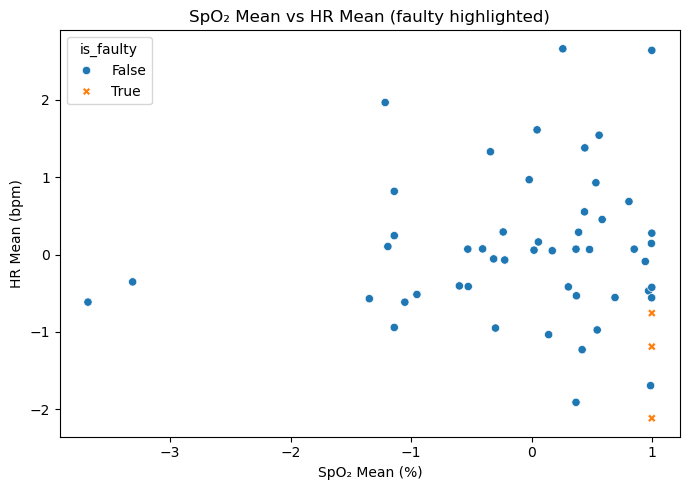

In [66]:
# Scatter: SpO2 mean vs HR mean, colored by is_faulty
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=features_df,
    x='spo2_mean', y='hr_mean',
    hue='is_faulty', style='is_faulty'
)
plt.title("SpO₂ Mean vs HR Mean (faulty highlighted)")
plt.xlabel("SpO₂ Mean (%)")
plt.ylabel("HR Mean (bpm)")
plt.tight_layout()
plt.show()

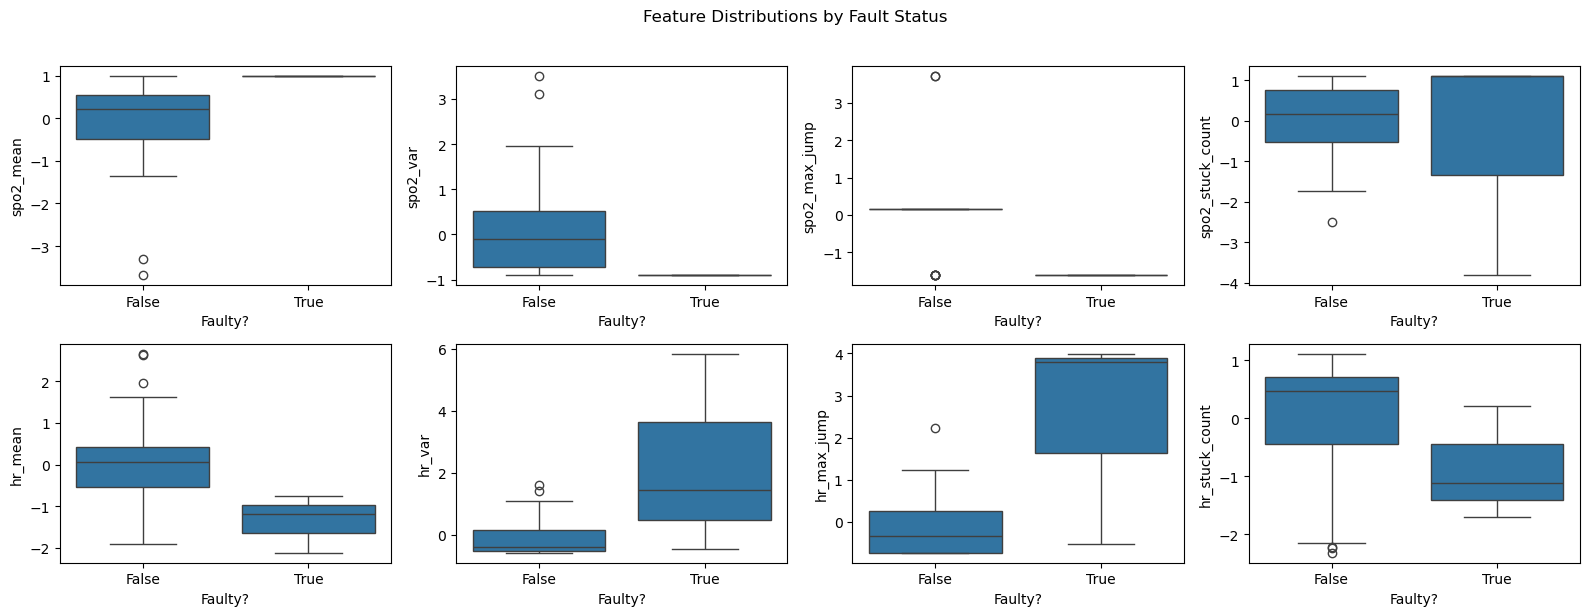

In [67]:
# Boxplots of features grouped by is_faulty
plot_features = ['spo2_mean','spo2_var','spo2_max_jump','spo2_stuck_count',
                 'hr_mean','hr_var','hr_max_jump','hr_stuck_count']

ncols = 4
nrows = int(np.ceil(len(plot_features)/ncols))
plt.figure(figsize=(4*ncols, 3*nrows))

for i, col in enumerate(plot_features, 1):
    plt.subplot(nrows, ncols, i)
    sns.boxplot(data=features_df, x='is_faulty', y=col)
    plt.xlabel('Faulty?')
    plt.ylabel(col)

plt.suptitle("Feature Distributions by Fault Status", y=1.02)
plt.tight_layout()
plt.show()

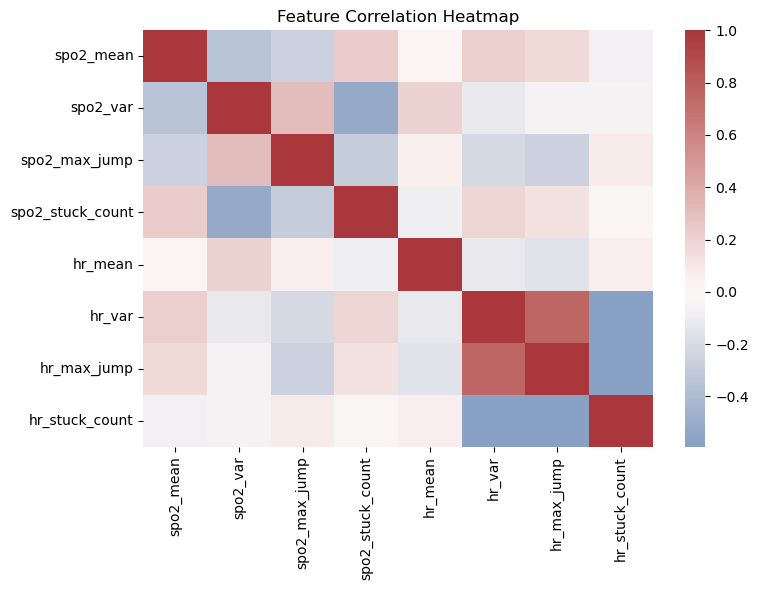

In [68]:
# Correlation heatmap of feature columns
corr = features_df[feature_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap="vlag", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

Top anomalies: ['bidmc_41_Numerics.csv', 'bidmc_45_Numerics.csv', 'bidmc_19_Numerics.csv']


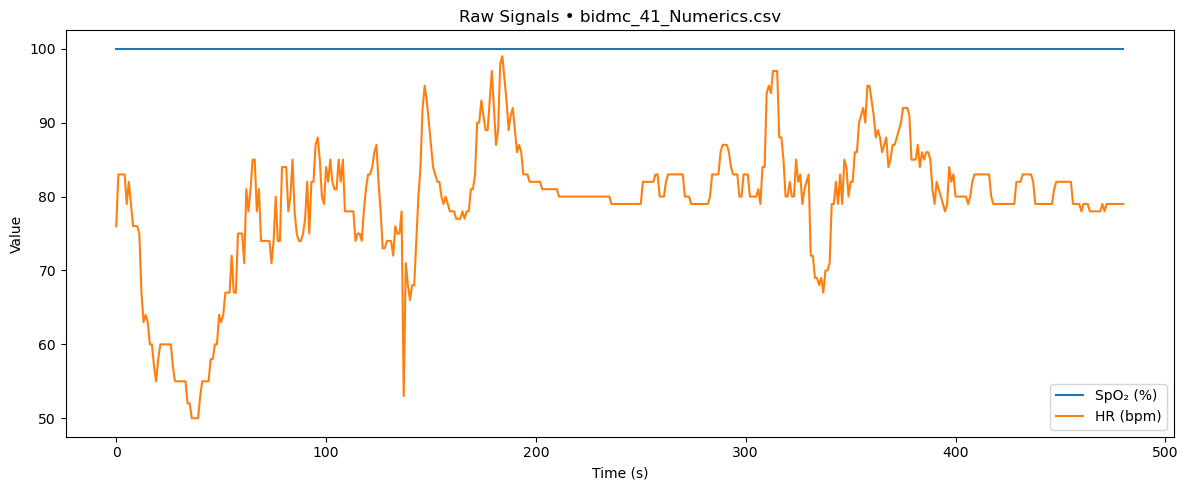

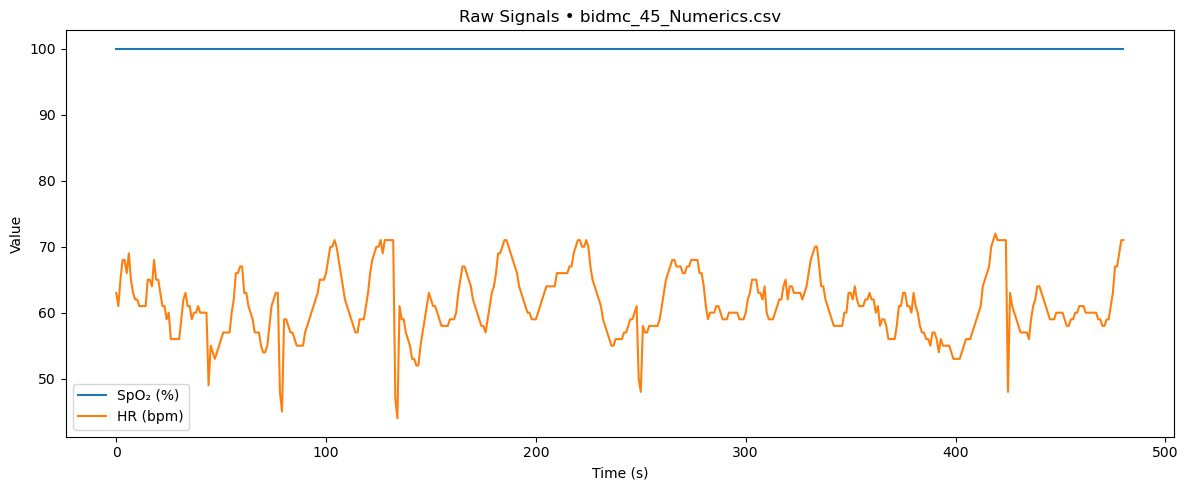

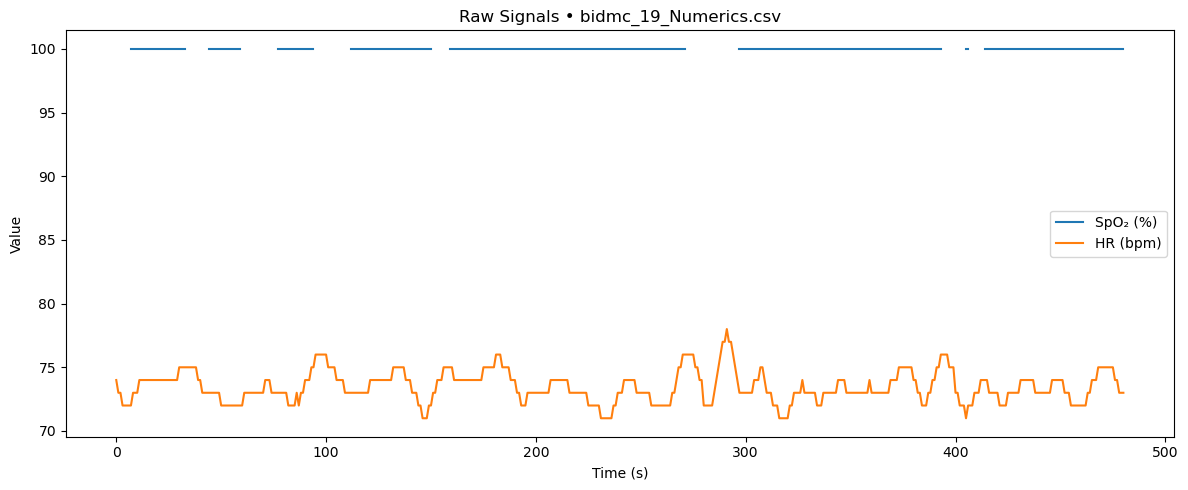

In [69]:
# Plot raw signals for top-K anomalies
top_k = 3
top_files = features_df.sort_values('anomaly_score', ascending=False)['recording'].head(top_k).tolist()
print("Top anomalies:", top_files)

for f in top_files:
    plot_signals(os.path.join(data_folder, f))

### Conclusion
- Extracted structured features from BIDMC pulse oximeter recordings.  
- Trained **Isolation Forest** on full recordings (unsupervised).  
- Assigned anomaly scores and flagged the top 5% as **potential faulty recordings**.  
- Visualized and inspected raw signals to validate anomalies.